In [25]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import os
from scipy.optimize import curve_fit
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

## Prepping Data

I just want to read the data in and make it nice and usable.

In [26]:
### LOAD DATA FROM FILES ###

## C20 phot data:
c20p_all = np.load(r"C:\Users\sikor\OneDrive\Desktop\BigData\Hyperion\Hyperion_C20_phot.npy", allow_pickle=True)

## C20 spec data:
c20s_all = np.loadtxt("Data/Hyperion_C20_spec.txt", dtype=object, skiprows=1)

# Try to turn spectra data to a float if possible
for idx in range(c20s_all.shape[1]):
    try:
        c20s_all[:,idx] = c20s_all[:,idx].astype(np.float32)    # Turn appropriate columns into floats
    except: pass

In [27]:
### DATA LIMITS ###
    ## Set the appropriate limits for Hyperion

IRAC_lim = 26
ra_range = (149.6, 150.52)  
dec_range = (1.74, 2.73)
z_range = (2.40, 2.55)

In [28]:
### APPLY DATA CUTS ###

## C20 Spectra
spec_ids = np.where((c20s_all[:,4] >= ra_range[0]) & (c20s_all[:,4] <= ra_range[1])     # RA
                & (c20s_all[:,6] >= dec_range[0]) & (c20s_all[:,6] <= dec_range[1]) )   # Dec

c20s = c20s_all[spec_ids]   # Cut spectra

## C20 phot
phot_ids = np.where((c20p_all["ALPHA_J2000"] >= ra_range[0]) & (c20p_all["ALPHA_J2000"] <= ra_range[1]) # RA
                & (c20p_all["DELTA_J2000"] >= dec_range[0]) & (c20p_all["DELTA_J2000"] <= dec_range[1]) # Dec
                & (c20p_all["IRAC_CH1_MAG"] <= IRAC_lim))   # Magnitude

c20p = c20p_all[phot_ids]       # Cut photometry

---
---
---


## Defining Hyperion Peaks

Here, I want to make a function that, given the limits of some physical cube (ra, dec, z) and an overdensity threshold, will return a list of galaxies which fall in the peaks and is considered part of Hyperion.

In [29]:
def definePeaks(gal_data, sigs, min_mass, zs, pk_sum, sig_cube, plot="None"):
    """
    INPUTS:
        - gal_data (array) - List of relevant data 
            - [ [ra, dec, z, mass, n_sigma, peak numbers, spec or photo] , ...  ]
        - sigs  (array) - Define the range of overdensities to test
            - [sig_min , sig_max) ---> If sig_max < 0, report all galaxies above sig_min. If sig_min == -99, report all galaxies 
                                       less than sig_max (useful for field)
        - min_mass (float)  - Mass-cutoff for peaks
        - zs    (array) - Define the redshift range to look at
            - [z_min, z_max]
        - pk_sum (array)    - Containing the peak summary data from find_peaks
        - sig_cube (.fits)  - The fits file containing the sigma-cube from find_peaks
        - plot (str)    - Plotting option
            - "None" = No plots
            - "show" = Show the plot in the terminal
            - directory = If you want to save, put the directory name to save to here
    OUTPUTS:
        - gal_data   (array)  - The list of galaxy data with only the members
        - volume    (float) - The volume of the relevant peaks (cMpc^3)
        - plot      - Depends on plotting option
    """


    ## Find position of each peak barycenter
    bRAs = np.interp(x = pk_sum[:,4], xp = np.arange(np.shape(sig_cube[1])[0]), fp = sig_cube[1].data)
    bdecs = np.interp(x = pk_sum[:,5], xp = np.arange(np.shape(sig_cube[2])[0]), fp = sig_cube[2].data)
    bzs = np.interp(x = pk_sum[:,6], xp = np.arange(np.shape(sig_cube[3])[0]), fp = sig_cube[3].data)

    b_coords = np.c_[bRAs, np.c_[bdecs, bzs]]   # Pack peak coordinates into array

    # Make cuts to find relevant peaks in the summary file
    g_idxs = np.where(  (b_coords[:,0] >= ra_range[0]) & (b_coords[:,0] <= ra_range[1])     # RAs
                & (b_coords[:,1] >= dec_range[0]) & (b_coords[:,1] <= dec_range[1])       # Decs
                & (b_coords[:,2] >= zs[0]) & (b_coords[:,2] <= zs[1])       # redshifts
                & (pk_sum[:,11] >= min_mass) )                      # Masses
    
    g_pks = pk_sum[g_idxs]      # List of relevant peak information
    g_coords = b_coords[g_idxs] # list of coordinates of relevant peaks


    ## Figure out galaxies are located in a good peak
    if sigs[0] == -99: # No lower limit provided (field)

        bad_Vol = 0  # Keep track of volume of bad peaks 
        test_idxs = np.where((gal_data[:,2] >= zs[0]) & (gal_data[:,2] <= zs[1]) )[0] # Gals in redshift range

        # Loop through each peak, find max mass, and add all galaxies to bad galaxies if needed.
        for pk in g_pks:
            pk_gal_idxs = np.where((gal_data[:,2] >= zs[0]) & (gal_data[:,2] <= zs[1])    # In relevant redshift
                          & (gal_data[:,5] == pk[0]) )[0]       # In the peak
            pk_gals = gal_data[pk_gal_idxs]     # Galaxies in the given peak
            
            # If max n-sigma is greater than max sigma entered, remove all these galaxies from the field
            if len(pk_gals) != 0:
                if np.max(pk_gals[:,4]) >= sigs[1]:
                    bad_Vol += pk[10]   # Add volume of peak to bad volume
                    # Remove all the indices from the list of good indices
                    bad_ids = np.in1d(test_idxs, pk_gal_idxs)
                    test_idxs = np.delete(test_idxs, bad_ids)
    
    elif sigs[1] >0: # Upper-bound provided for sigma
        mask = np.in1d(gal_data[:,5], g_pks[:,0])   # Make mask for if peak number is in relevant peak
        test_idxs = np.where((gal_data[:,2] >= zs[0]) & (gal_data[:,2] <= zs[1])    # In relevant redshift
                          & (gal_data[:,4] >= sigs[0]) & (gal_data[:,4] < sigs[1]) # In relevant overdensity regime
                           & mask )    # In relevant peak
    else:   # Assume no upperbound for sigma
        mask = np.in1d(gal_data[:,5], g_pks[:,0])   # Make mask for if peak number is in relevant peak
        test_idxs = np.where((gal_data[:,2] >= zs[0]) & (gal_data[:,2] <= zs[1])    # In relevant redshift
                          & (gal_data[:,4] >= sigs[0])   # In relevant overdensity
                          & mask )    # In relevant peak


    

    good_gals = gal_data[test_idxs]     # Trim down to galaxies which may be in a peak
    bad_gals = np.delete(gal_data, test_idxs, axis=0)   # Galaxies which aren't used.
    bad_gals = bad_gals[np.where((bad_gals[:,2] >= zs[0]) & (bad_gals[:,2] <= zs[1]))]    # In relevant redshift

    ## Find the total volume of the relevant peaks
    if sigs[0] != -99:
        unique_peaks = []   # Keep track of which peaks have been counted
        Vol = 0 # Total volume of peaks
        for g in good_gals:
            if g[5] not in unique_peaks:
                unique_peaks.append(g[5])   # add to list to not double count
                Vol += pk_sum[int(g[5]-1)][10]  # Add the volume only if new peak. 
    else: Vol = bad_Vol # Calculated earlier in function


    ## Plot results
    if plot != "None":

        style_dict = {          # Dictionary of all the styles
            12: ['*', 'red', "[12,12.5)"], 12.5: ['h', 'gold', "[12.5,13)"], 13: ['o', 'deepskyblue', "[13,13.5)"],
            13.5: ['X', 'darkorange', "[13.5,14)"], 14 :['>', 'forestgreen', "[14,14.5)"], 14.5 : ['s', 'royalblue', "[14.5,15)"], 
            15 :['D', 'maroon', r"M $\geq15$"]  }
        ## Set up gridspec plot
        fig = plt.figure(figsize=(14,10))
        gs = gridspec.GridSpec(2, 1, wspace=0)

        # Row 1 -- plotting peak locations
        row = gs[0].subgridspec(1,2, width_ratios=[1,1.5])
        ax00, ax01 = fig.add_subplot(row[0]), fig.add_subplot(row[1], projection='3d')

        round_ms = np.array([min(15,m//0.5/2) for m in g_pks[:,11]])   # Rounded masses that dictate the plotting style

        for k in list(style_dict.keys()):
            peaks = np.where(k == round_ms)[0]      # Find which peaks are in the given mass-bin

            if len(peaks) != 0: # If there are some peaks in the mass-bin:

                # 2D plot
                ax00.scatter(g_coords[peaks][:,0], g_coords[peaks][:,1], marker=style_dict[k][0],
                             c=style_dict[k][1], s=100, label=style_dict[k][2])  
                # 3D plot
                ax01.scatter(g_coords[peaks][:,2], g_coords[peaks][:,0], g_coords[peaks][:,1],
                     marker=style_dict[k][0], c=style_dict[k][1], s=100, label=style_dict[k][2])
                
        # Clean up plots after all points are plotted
        ax00.set(title="Peak Locations", xlim=ra_range, ylim=dec_range, xlabel="RA (deg)", ylabel="Dec (deg)")
        ax00.legend(title = r"$\log_{10}(M_*)\in$")
        ax00.invert_xaxis()
        ax01.set(title="Peak Locations", xlim=zs, ylim=ra_range, zlim=dec_range, xlabel="z", ylabel="RA (deg)", zlabel="Dec (deg)")
        ax01.legend(title = r"$\log_{10}(M_*)\in$")
        ax01.set_box_aspect((5,5,3), zoom=1.2)
        ax01.view_init(25)
        ax01.invert_yaxis()
        ax01.invert_xaxis()

        # Row 2 -- Plotting good vs bad galaxies
        row = gs[1].subgridspec(1,2, width_ratios=[1,1.5])
        ax10, ax11 = fig.add_subplot(row[0]), fig.add_subplot(row[1], projection='3d')

        # 2D
        ax10.scatter(good_gals[:,0], good_gals[:,1], marker='.', c='g') # Usable galaxies
        ax10.scatter(bad_gals[:,0], bad_gals[:,1], marker='.', c='r', alpha=0.25, label=f"{len(bad_gals)} unsuable gals") # Unusable galaxies

        # 3D
        ax11.scatter(good_gals[:,2], good_gals[:,0], good_gals[:,1], marker='.', c='g', label=f"{len(good_gals)} usable galaxies")

        # Clean up plots
        ax10.set(title="Usability of Galaxies", xlim=ra_range, ylim=dec_range, xlabel="RA (deg)", ylabel="Dec (deg)")
        ax10.invert_xaxis()
        ax10.legend()
        ax11.set(title="Usable Galaxies", xlim=zs, ylim=ra_range, zlim=dec_range, xlabel="z", ylabel="RA (deg)", zlabel="Dec (deg)")
        ax11.set_box_aspect((5,5,3), zoom=1.2)
        ax11.view_init(25)
        ax11.legend()
        ax11.invert_yaxis()
        ax11.invert_xaxis()
        if sigs[1] > 0:
            fig.suptitle(rf"$\sigma \in$ [{sigs[0]}, {sigs[1]})", fontsize=18)
        else:
            fig.suptitle(rf"$\sigma \geq$ {sigs[0]}", fontsize=18)
    

    # Show/save plots
    if plot in ("show", "Show"): plt.show()
    else:
        if sigs[1] >0:
            try: plt.savefig(plot + f"\Sigma_{sigs[0]}_{sigs[1]}_plot.png")
            except:
                try:
                    os.mkdir(plot)
                    plt.savefig(plot + f"\Sigma_{sigs[0]}_{sigs[1]}_plot.png")
                except: print("Unable to make plot")
        else:
            try: plt.savefig(plot + f"\Sigma_{sigs[0]}_plot.png")
            except:
                try:
                    os.mkdir(plot)
                    plt.savefig(plot + f"\Sigma_{sigs[0]}_plot.png")
                except: print("Unable to make plot")
    plt.close()
    return good_gals, Vol

In [30]:
## DEFINE THE PEAKS ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")
all_gals = []
ggs1 = []    # Member galaxies
Vols1 = []
ggs2 = []
Vols2 = []

sigs = [2.0, 3.0, 4.0]

# For each sigma, run "DefinePeaks"
for si, sig in enumerate(sigs):
    gs = [] # Temp. storage
    for s in c20s:
        gs.append([s[4], s[6], s[11], s[15], s[-8], s[-int(2*si+1)], 1])   # Spectra
    for t, p in enumerate(c20p):
        gs.append([p["ALPHA_J2000"], p["DELTA_J2000"], p["lp_zPDF"], p["lp_mass_med"], p["n_sigma"], p[f"sigma_{sig}"], 0])   # Photoz
    all_gals.append(np.array(gs))


    p_sum = np.genfromtxt(f"HyperionPeaks_new/peaks_sig{sig}.dat", dtype=float)
    g1, V1 = definePeaks(np.array(gs), [sig, -99], 13.0, [2.4,2.55], p_sum,  sig_cube, plot="HyperionPlots2")
    if sig != sigs[-1]:
        g2, V2 = definePeaks(np.array(gs), [sig, sig+1], 13.0, [2.4,2.55], p_sum,  sig_cube, plot="HyperionPlots2")
    else:
        g2, V2 = definePeaks(np.array(gs), [sig, -99], 13.0, [2.4,2.55], p_sum,  sig_cube, plot="HyperionPlots2")


    ggs1.append(g1)     # inclusive binning
    Vols1.append(V1)
    ggs2.append(g2)     # Exclusive binning
    Vols2.append(V2)

ggs1 = np.array(ggs1, dtype=object)
ggs2 = np.array(ggs2, dtype=object)

all_gals = np.array(all_gals, dtype=object)

In [31]:
def smfBin(gal_masses, m_range, m_step):

    Ns = [] # List number of galaxies in each mass bin
    ms = []
    mass = m_range[0]   # Start at minimum mass

    while mass <= m_range[1]:

        gals = np.where( (gal_masses >= mass) & (gal_masses < mass + m_step) )[0]
        Ns.append(len(gals))
        if len(gals) != 0:
            ms.append(np.median(gal_masses[gals]))
        else:
            ms.append(mass) # If N = 0

        mass += m_step
    return np.array(ms), np.array(Ns)

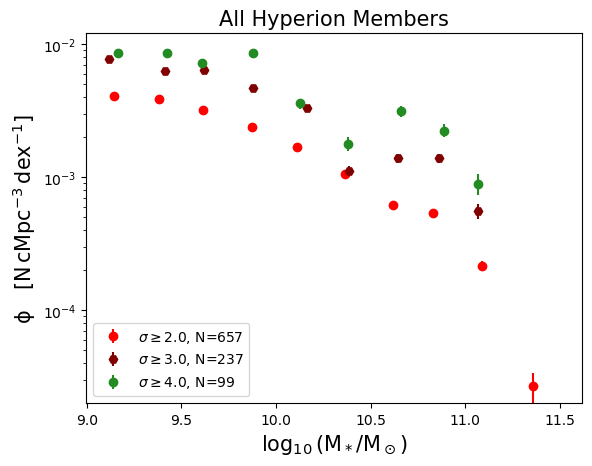

In [32]:
### METHOD 1 -- All ###

sigs = [2.0, 3.0, 4.0,]
colors = ['red', "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]
m_range = [9.0, 11.5]
m_step = 0.25

for id, g in enumerate(ggs1):
    ms, Ns = smfBin(g[:,3], m_range, m_step)

    l = rf"$\sigma \geq {sigs[id]}$, N={sum(Ns)}" # if id !=0 else "Field"
    ns = Ns/ Vols1[id] / m_step
    plt.errorbar(x=ms, y=ns, yerr=np.sqrt(Ns)/Vols1[id], c=colors[id], marker=shapes[id], ls='', label=l)

plt.yscale('log')
plt.legend(loc="lower left")
plt.title(f"All Hyperion Members", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)

plt.show()

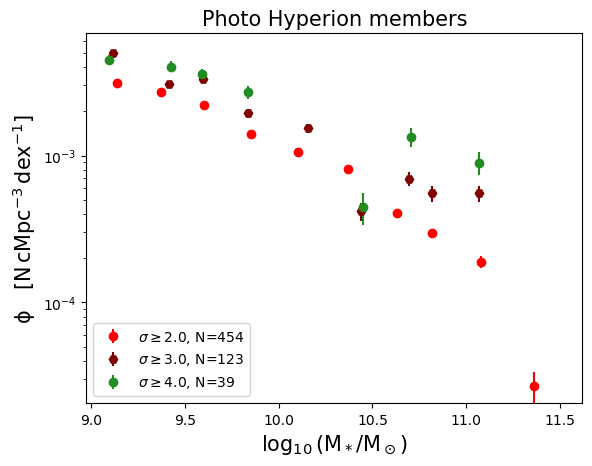

In [33]:
### METHOD 1 -- photozs ###

sigs = [2.0, 3.0, 4.0,]
colors = ['red', "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]
m_range = [9.0, 11.5]
m_step = 0.25

for id, g in enumerate(ggs1):
    gs = g[np.where(g[:,-1] == 0)]
    ms, Ns = smfBin(gs[:,3], m_range, m_step)

    l = rf"$\sigma \geq {sigs[id]}$, N={sum(Ns)}" # if id !=0 else "Field"
    ns = Ns/ Vols1[id] / m_step
    plt.errorbar(x=ms, y=ns, yerr=np.sqrt(Ns)/Vols1[id], c=colors[id], marker=shapes[id], ls='', label=l)

plt.yscale('log')
plt.legend(loc="lower left")
plt.title(f"Photo Hyperion members", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)

plt.show()

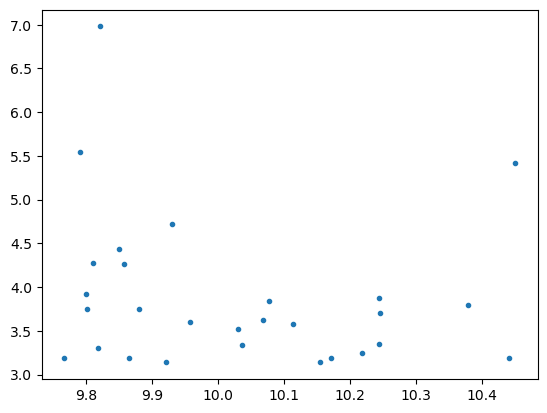

In [34]:
test = ggs1[1][np.where((ggs1[1][:,3] > 9.75) & (ggs1[1][:,3] < 10.5) & (ggs1[1][:,-1] == 0))]
plt.scatter(test[:,3], test[:,4], marker='.')

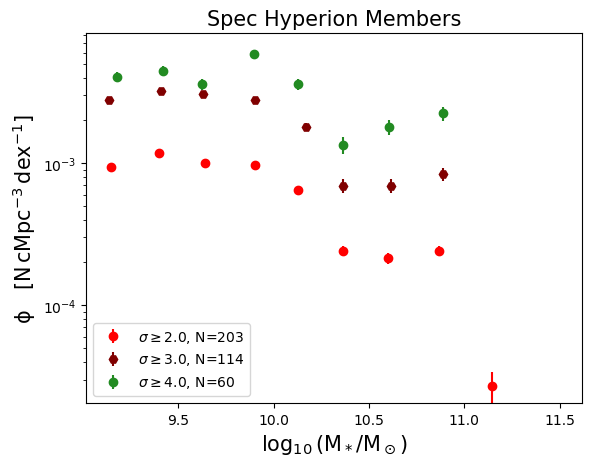

In [35]:
### METHOD 1 -- speczs ###

sigs = [2.0, 3.0, 4.0,]
colors = ['red', "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]
m_range = [9.0, 11.5]
m_step = 0.25

for id, g in enumerate(ggs1):
    g = g[np.where(g[:,-1] == 1)]
    ms, Ns = smfBin(g[:,3], m_range, m_step)

    l = rf"$\sigma \geq {sigs[id]}$, N={sum(Ns)}" # if id !=0 else "Field"
    ns = Ns/ Vols1[id] / m_step
    plt.errorbar(x=ms, y=ns, yerr=np.sqrt(Ns)/Vols1[id], c=colors[id], marker=shapes[id], ls='', label=l)

plt.yscale('log')
plt.legend(loc="lower left")
plt.title(f"Spec Hyperion Members", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)

plt.show()

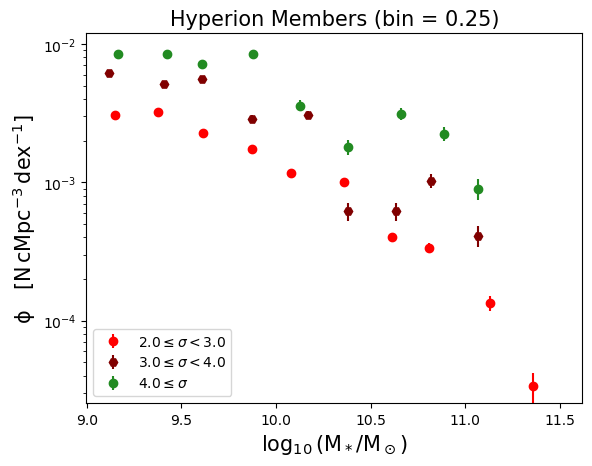

In [36]:
### METHOD 2 ###

sigs = [2.0, 3.0, 4.0]
colors = ['red', "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]
m_range = [9.0, 11.5]
m_step = 0.25

for id, g in enumerate(ggs2):
    ms, Ns = smfBin(g[:,3], m_range, m_step)

    l = rf"${sigs[id]} \leq \sigma < {sigs[id+1]}$" if id != len(sigs)-1 else rf"$ {sigs[id]}\leq \sigma $"
    if id != len(sigs)-1: v = Vols2[id] - Vols2[id +1]
    else: v = Vols2[id]
    ns = Ns/ v /m_step
    plt.errorbar(x=ms, y=ns, yerr=np.sqrt(Ns)/v, c=colors[id], marker=shapes[id], ls='', label=l)

plt.yscale('log')
plt.legend(loc="lower left")
plt.title(f"Hyperion Members (bin = {m_step})", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)

plt.show()

---
---
---

## Field Samples

In [37]:
def AP_coVol(ra, dec, zs):
    """
    Return a comoving volume using Astropy in Mpc^3
    """
    theta_dec = np.abs(dec[1]-dec[0])*np.pi/180 * u.rad
    theta_RA  = np.abs(ra[0]-ra[1])*np.pi/180 * u.rad * np.cos(theta_dec)
    Omega     = (theta_RA * theta_dec).to(u.steradian).value # get rid of unit

    V         = Omega/(4*np.pi) *(cosmo.comoving_volume(zs[1]) - cosmo.comoving_volume(zs[0]))

    return V.value

In [38]:
## DEFINE THE FIELDS ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")
fields = []
fieldsV = []

## Find Number of galaxies
fsig = 2.0      # Which peak file to use
si = 1          # negative index in .txt file for peak info
max_sig = 70   # Threshold to check when removing peaks

p_sum = np.genfromtxt(f"HyperionPeaks_new/peaks_sig{fsig}.dat", dtype=float)

gs = [] # Temp. storage
for s in c20s:
    gs.append([s[4], s[6], s[11], s[15], s[-8], s[-1], 1])   # Spectra
for t, p in enumerate(c20p):
    gs.append([p["ALPHA_J2000"], p["DELTA_J2000"], p["lp_zPDF"], p["lp_mass_med"], p["n_sigma"], p[f"sigma_{fsig}"], 0])   # Photoz

gs = np.array(gs)
z_range1 = [np.min(gs[:,2]), 2.5]
z_range2 =  [2.5, np.max(gs[:,2])]

f1, V1 = definePeaks(gs, [-99, max_sig], 0, z_range1, p_sum, sig_cube, plot="Fields1")
f2, V2 = definePeaks(gs, [-99, max_sig], 0, z_range2, p_sum, sig_cube, plot="Fields2")


fields.append(f1)
fields.append(f2)

## Find volume of cubes
fieldsV.append(AP_coVol(ra_range, dec_range, z_range1)-V1)
fieldsV.append(AP_coVol(ra_range, dec_range, z_range2)-V2)

print(V1, V2)

0 0


Volumes =  [5448587.890224717, 5440034.129528867]


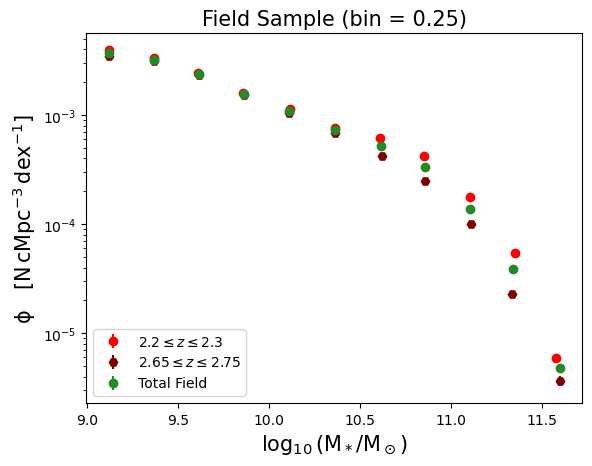

In [39]:
colors = ['red', "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]
m_range = [9.0, 11.5]
m_step = 0.25

## Field 1
m1, N1 = smfBin(fields[0][:,3], m_range, m_step)
n1 = N1/ fieldsV[0] / m_step
plt.errorbar(x=m1, y=n1, yerr=np.sqrt(N1)/fieldsV[0], c=colors[0], marker=shapes[0], ls='', label=r'$2.2\leq z\leq 2.3$')

## Field 2
m2, N2 = smfBin(fields[1][:,3], m_range, m_step)
n2 = N2/ fieldsV[1] /m_step 
plt.errorbar(x=m2, y=n2, yerr=np.sqrt(N2)/fieldsV[1], c=colors[1], marker=shapes[1], ls='', label=r'$2.65\leq z \leq 2.75$')

print("Volumes = ", fieldsV)

## Combined
tot_field = np.concatenate((fields[0], fields[1]), axis=0)
mt, Nt = smfBin(tot_field[:,3], m_range, m_step)
nt = Nt/ sum(fieldsV) /m_step
plt.errorbar(x=mt, y=nt, yerr=np.sqrt(Nt)/sum(fieldsV), c=colors[2], marker=shapes[2], ls='', label=r'Total Field')


plt.yscale('log')
plt.legend(loc="lower left")
plt.title(f"Field Sample (bin = {m_step})", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)

plt.show()

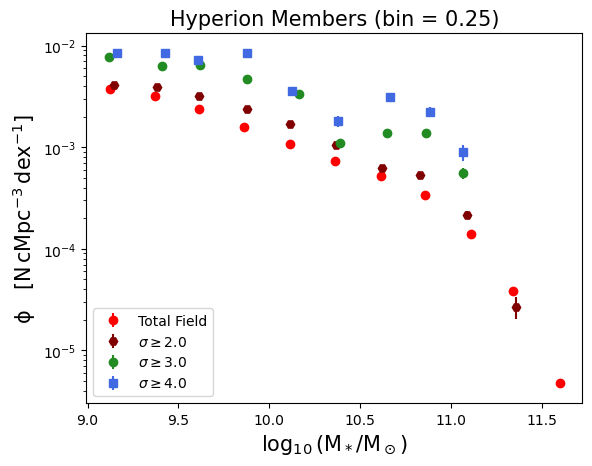

In [40]:
sigs = [2.0, 3.0, 4.0,]
colors = ["red", "maroon", "forestgreen", "royalblue", 'magenta']
shapes = ["o", "H", "o", "s", "D"]
m_range = [9.0, 11.5]
m_step = 0.25

## Field
plt.errorbar(x=mt, y=nt, yerr=np.sqrt(Nt)/sum(fieldsV), c='red', marker='o', ls='', label=r'Total Field')

smfs = []
smfs.append(np.c_[mt, Nt, nt])
## Galaxies
for id, g in enumerate(ggs1):
    ms, Ns = smfBin(g[:,3], m_range, m_step)

    l = rf"$\sigma \geq {sigs[id]}$" # if id !=0 else "Field"
    ns = Ns/ Vols1[id] /m_step
    smfs.append(np.c_[ms, Ns, ns])
    plt.errorbar(x=ms, y=ns, yerr=np.sqrt(Ns)/Vols1[id], c=colors[id+1], marker=shapes[id+1], ls='', label=l)

plt.yscale('log')
plt.legend(loc="lower left")
plt.title(f"Hyperion Members (bin = {m_step})", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)

plt.show()


smfs = np.array(smfs)

---
---
---

## Fitting Functions

In [41]:
def schechter(M, phi_star, alpha, m_star):
  return np.log(10)*phi_star*10**((M-m_star)*(1+alpha))*np.exp(-10**(M-m_star))

In [42]:
def Dschechter(M, M_star, phi_s1, phi_s2, alpha_1, alpha_2):
    return np.log(10)*np.exp(-10**(M-M_star))*(phi_s1*(10**(M-M_star))**(alpha_1+1) \
    +phi_s2*(10**(M-M_star))**(alpha_2+1) )

In [43]:
def C20field(m, fn):
    if fn == 0:
        return Dschechter(m, 10.78,0.27e-3, 0.27e-3, -1.46, 0.07 )
    else:
        return schechter(m, 0.24e-3, -1.46, 10.97)

0.000203459905809666
0.0004818844465899583
0.0005028011385365918
0.0007387982821775911


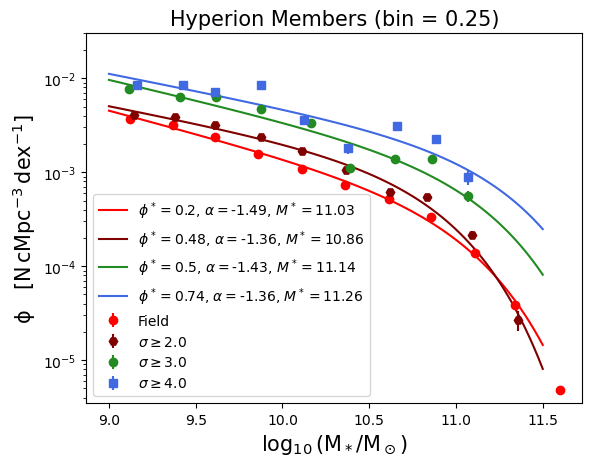

In [44]:
ms = np.linspace(m_range[0], m_range[1], 100)
sigs = [2.0, 3.0, 4.0]
for i, s in enumerate(smfs):

    l = "Field" if i == 0 else rf"$\sigma \geq {sigs[i-1]}$"
    vol = sum(fieldsV) if i == 0 else Vols1[i-1]
    fit_ids = np.where(s[:,1] != 0)
    s = s[fit_ids]
    plt.errorbar(x=s[:,0], y=s[:,2], yerr=np.sqrt(s[:,1])/vol, c=colors[i], marker=shapes[i], ls='', label=l)
    fit, error = curve_fit(schechter, s[:,0],s[:,2], p0=[1, -1, 10], maxfev=2000, sigma=np.sqrt(s[:,1])/vol)

    l_l = rf"$\phi^*=${round(fit[0]/1e-3,2)}, $\alpha=${round(fit[1],2)}, $M^*=${round(fit[2],2)}"
    plt.plot(ms, schechter(ms, *fit), c=colors[i], label=l_l)
    print(fit[0])


plt.yscale("log")
plt.ylim(3.5e-6, 3e-2)
plt.legend(loc='lower left')
plt.title(f"Hyperion Members (bin = {m_step})", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)
plt.show()

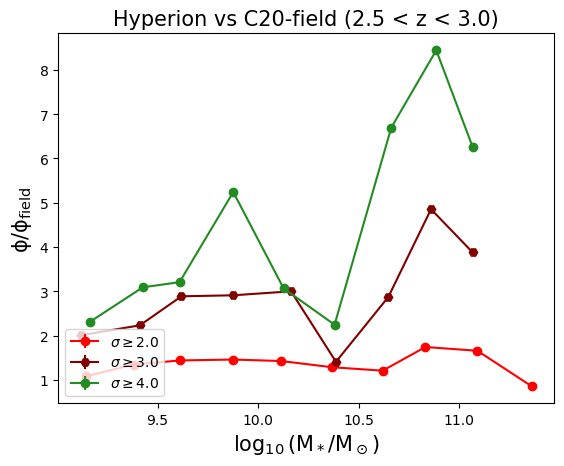

In [45]:
sigs = [2.0, 3.0, 4.0]
for i, s in enumerate(smfs[1:]):

    l = rf"$\sigma \geq {sigs[i]}$"
    vol = Vols1[i]
    check = np.where(s[:,1] != 0)
    s = s[check]

    # field = smfs[0][:,2][check]
    # plt.title(f"Hyperion vs My Field", fontsize=15)

    # field = C20field(s[:,0], 0)
    # plt.title(f"Hyperion vs C20-field (2.0 < z < 2.5)", fontsize=15)

    field = C20field(s[:,0], 1)
    plt.title(f"Hyperion vs C20-field (2.5 < z < 3.0)", fontsize=15)

    plt.errorbar(x=s[:,0], y=s[:,2] / field , yerr=np.sqrt(s[:,1])/vol, c=colors[i], marker=shapes[i], label=l)


# plt.yscale("log")
# plt.ylim(3.5e-6, 3e-2)
plt.legend(loc='lower left')
plt.ylabel(r"$\rm \phi / \phi_{field}$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)
plt.show()

In [46]:
print(fieldsV)
test = AP_coVol(ra_range, dec_range, [np.min(gs[:,2]), 2.5])
print(test)

[5448587.890224717, 5440034.129528867]
5448587.890224717


[ 2.38232345e-04 -1.47216223e+00  1.09047913e+01]


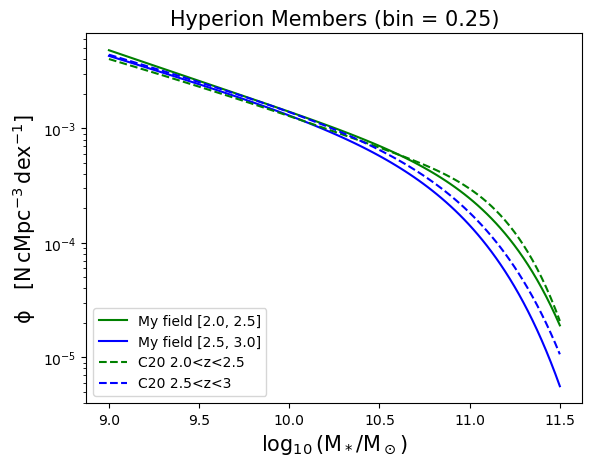

In [47]:
### FIELD COMPARISON -- Free variables###
ms = np.linspace(m_range[0], m_range[1], 100)

## TOTAL FIELD
# s = smfs[0]     # My field sample
# vol = sum(fieldsV)
# fit, error = curve_fit(Dschechter, s[:,0], s[:,2], p0=[10.5,1e-4,1e-4,-1, -1], maxfev=5000, sigma=np.sqrt(s[:,1])/vol, 
#                            bounds=([10, 1e-5, 1e-5, -2, -2], [12, 1e-2, 1e-2, -0.75, -0.75]))

## SEPARATE FIELDS
test1 = fields[0][np.where(fields[0][:,-1]) == 0]
m1, N1 = smfBin(fields[0][:,3], m_range, m_step)

n1 = N1/ fieldsV[0] / m_step
f1, _ = curve_fit(Dschechter, m1, n1, p0=[10.5,1e-4,1e-4,-1, -1], maxfev=5000, sigma=np.sqrt(N1)/fieldsV[0], 
                           bounds=([10, 1e-5, 1e-5, -2, -2], [12, 1e-2, 1e-2, -0.75, -0.75]))

test2 = fields[1][np.where(fields[1][:,-1]) == 0]
m2, N2 = smfBin(fields[1][:,3], m_range, m_step)


n2 = N2/ fieldsV[1] /m_step 
f2, _ = curve_fit(schechter, m2, n2, p0=[1e-4, -1, 10.5], maxfev=5000, sigma=np.sqrt(N2)/fieldsV[1]
                           )


# plt.plot(ms, Dschechter(ms, *fit), c="red", label="My field sample")
plt.plot(ms, Dschechter(ms, *f1), c="g", label=f"My field {z_range1}")
plt.plot(ms, schechter(ms, *f2), c="b", label=f"My field {z_range2}")
print(f2)


plt.plot(ms, Dschechter(ms, 10.78,0.27e-3, 0.27e-3, -1.46, 0.07), 'g--', label="C20 2.0<z<2.5")
plt.plot(ms, schechter(ms, 0.24e-3, -1.46, 10.97 ), 'b--', label="C20 2.5<z<3")

# combo = (smfs[0][:,1] + smfs[1][:,1]) / (sum(fieldsV) + Vols1[0]) /0.25
# fit, error = curve_fit(Dschechter, (smfs[0][:,0]+smfs[1][:,0])/2, combo, p0=[10.5,1e-4,1e-4,-1, -1], 
#                        maxfev=5000, sigma=np.sqrt(smfs[0][:,1] + smfs[1][:,1]) / (sum(fieldsV) + Vols1[0]), bounds=([10, 1e-5, 1e-5, -2, -2], [12, 1e-2, 1e-2, -0.75, -0.75]))

# plt.plot(ms, Dschechter(ms, *fit), c="k", label=r"My field + Hyperion ($\sigma \geq 2$)")


plt.yscale("log")
# plt.ylim(3.5e-6, 3e-2)
plt.legend(loc='lower left')
plt.title(f"Hyperion Members (bin = {m_step})", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)
plt.show()

[ 2.40978154e-04 -1.47000000e+00  1.09010703e+01]


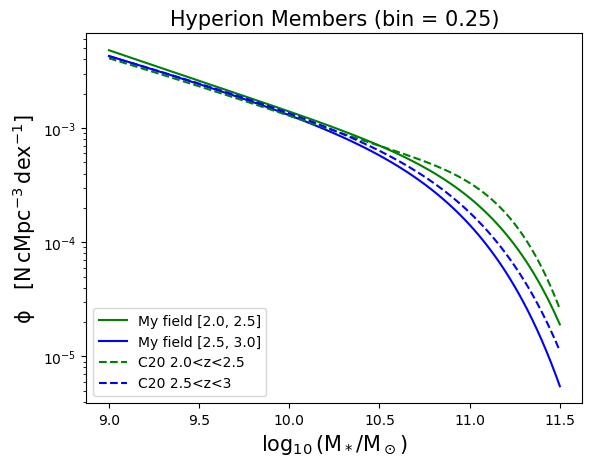

In [48]:
### FIELD COMPARISON -- Fixed variables###
ms = np.linspace(m_range[0], m_range[1], 100)

## TOTAL FIELD
# s = smfs[0]     # My field sample
# vol = sum(fieldsV)
# fit, error = curve_fit(Dschechter, s[:,0], s[:,2], p0=[10.5,1e-4,1e-4,-1, -1], maxfev=5000, sigma=np.sqrt(s[:,1])/vol, 
#                            bounds=([10, 1e-5, 1e-5, -2, -2], [12, 1e-2, 1e-2, -0.75, -0.75]))

## SEPARATE FIELDS
m1, N1 = smfBin(fields[0][:,3], m_range, m_step)
n1 = N1/ fieldsV[0] / m_step
f1, _ = curve_fit(Dschechter, m1, n1, p0=[10.5,1e-4,1e-4,-1, -1], maxfev=5000, sigma=np.sqrt(N1)/fieldsV[0], 
                           bounds=([10, 1e-5, 1e-5, -2, -2], [12, 1e-2, 1e-2, -0.75, -0.75]))

m2, N2 = smfBin(fields[1][:,3], m_range, m_step)
n2 = N2/ fieldsV[1] /m_step 
f2, _ = curve_fit(schechter, m2, n2, p0=[1e-4, -1.46, 10.5], maxfev=5000, sigma=np.sqrt(N2)/fieldsV[1],
                        bounds = ([1e-5, -1.47, 10 ], [1e-2,-1.45, 11 ])   )


# plt.plot(ms, Dschechter(ms, *fit), c="red", label="My field sample")
plt.plot(ms, Dschechter(ms, *f1), c="g", label=f"My field {z_range1}")
plt.plot(ms, schechter(ms, *f2), c="b", label=f"My field {z_range2}")
print(f2)


plt.plot(ms, Dschechter(ms, 10.79, 0.26e-3, 0.31e-3, -1.47, 0.07), 'g--', label="C20 2.0<z<2.5")
plt.plot(ms, schechter(ms, 0.23e-3, -1.46, 10.98 ), 'b--', label="C20 2.5<z<3")

# combo = (smfs[0][:,1] + smfs[1][:,1]) / (sum(fieldsV) + Vols1[0]) /0.25
# fit, error = curve_fit(Dschechter, (smfs[0][:,0]+smfs[1][:,0])/2, combo, p0=[10.5,1e-4,1e-4,-1, -1], 
#                        maxfev=5000, sigma=np.sqrt(smfs[0][:,1] + smfs[1][:,1]) / (sum(fieldsV) + Vols1[0]), bounds=([10, 1e-5, 1e-5, -2, -2], [12, 1e-2, 1e-2, -0.75, -0.75]))

# plt.plot(ms, Dschechter(ms, *fit), c="k", label=r"My field + Hyperion ($\sigma \geq 2$)")


plt.yscale("log")
# plt.ylim(3.5e-6, 3e-2)
plt.legend(loc='lower left')
plt.title(f"Hyperion Members (bin = {m_step})", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)
plt.show()

[ 1.06331372e+01  3.73190580e-04  2.02352465e-04 -1.44457238e+00
  5.00000000e-01]
[ 1.06133858e+01  6.72958138e-04  2.16476140e-04 -1.32048560e+00
  5.00000000e-01]
[ 1.06675881e+01  9.72198971e-04  5.73800621e-04 -1.38117325e+00
  4.99999991e-01]
[ 1.06315132e+01  1.47367322e-03  1.30406889e-03 -1.32153340e+00
  4.99999983e-01]


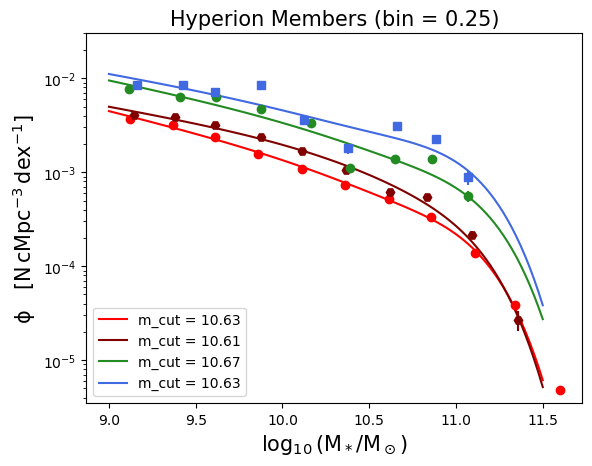

In [49]:
ms = np.linspace(m_range[0], m_range[1], 100)
sigs = [2.0, 3.0, 4.0]
for i, s in enumerate(smfs):

    l = "Field" if i == 0 else rf"$\sigma \geq {sigs[i-1]}$"
    vol = sum(fieldsV) if i == 0 else Vols1[i-1]
    fit_ids = np.where(s[:,1] != 0)
    s = s[fit_ids]

    plt.errorbar(x=s[:,0], y=s[:,2], yerr=np.sqrt(s[:,1])/vol, c=colors[i], marker=shapes[i], ls='')
    fit, error = curve_fit(Dschechter, s[:,0], s[:,2], p0=[10.5,1e-4,1e-4,-1, 0], maxfev=5000, sigma=np.sqrt(s[:,1])/vol, 
                            bounds=([10, 1e-5, 1e-5, -2, -0.5], [12, 1e-2, 1e-2, 1, 0.5]))

    l_l = rf"m_cut = {round(fit[0], 2)}"

    plt.plot(ms, Dschechter(ms, *fit), c=colors[i], label=l_l)
    print(fit)

plt.yscale("log")
plt.ylim(3.5e-6, 3e-2)
plt.legend(loc='lower left')
plt.title(f"Hyperion Members (bin = {m_step})", fontsize=15)
plt.ylabel(r"$\rm \phi \quad [N\, cMpc^{-3}\,dex^{-1}]$", fontsize=15)
plt.xlabel(r"$\rm \log_{10}(M_*/M_\odot)$", fontsize=15)
plt.show()